# MMA 867 - Individual Assignment
## Kaggle Competition - House Prices - Advanced Regression Techniques
### By Gopala Goyal - 20254605

>As a part of this assignment, we would be performing predictive analysis on Housing price data from Kaggle and estimating the prices of houses in Iowa and other parts of the US where is the data is based on.

> The flow of the assignment would be
>1. Collecting, gathering and importing data
>2. Performing Exploratory Data Analysis (EDA) where we see what the data is and how it is structured, and check for any discrepancies in the data
>3. Data Wrangling Process - Clean, structure and prepare data for predictive analysis
>4. Developing regression model to predict housing prices for test data
>5. Reporting outcomes

In [1]:
#Import the required libraries
import pandas as pd
import numpy as np
import matplotlib as mplt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

In [2]:
hp_train_df = pd.read_csv("train.csv")
hp_test_df = pd.read_csv("test.csv")
hp_train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
hp_train_df.describe()

In [ ]:
hp_train_df.info()

In [3]:
#Backup DataFrame
hp_tr = hp_train_df
hp_te=hp_test_df

##### We would use hp_tr as training data and hp_te as test data for this project
### Data exploration

/Users/apple/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


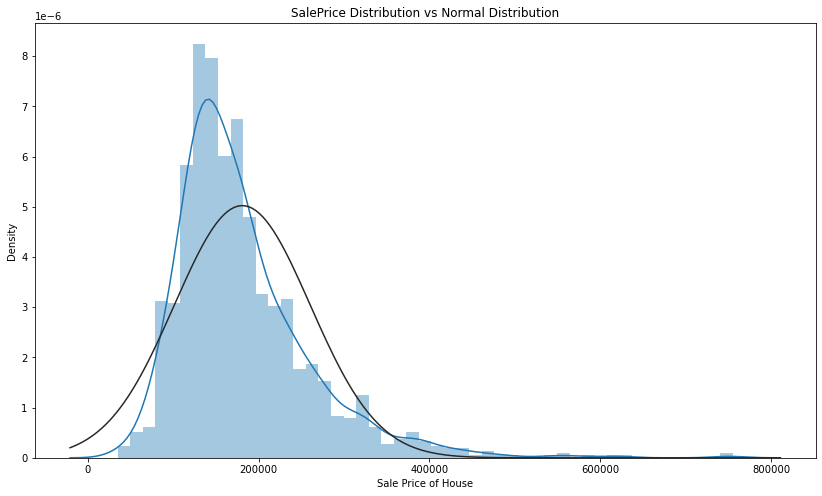

In [4]:
plt.figure(figsize = (14,8))
sns.distplot(hp_tr['SalePrice'], kde= True, hist=True, fit = norm)
plt.xlabel('Sale Price of House')
plt.title('SalePrice Distribution vs Normal Distribution')
plt.show()

<AxesSubplot:>

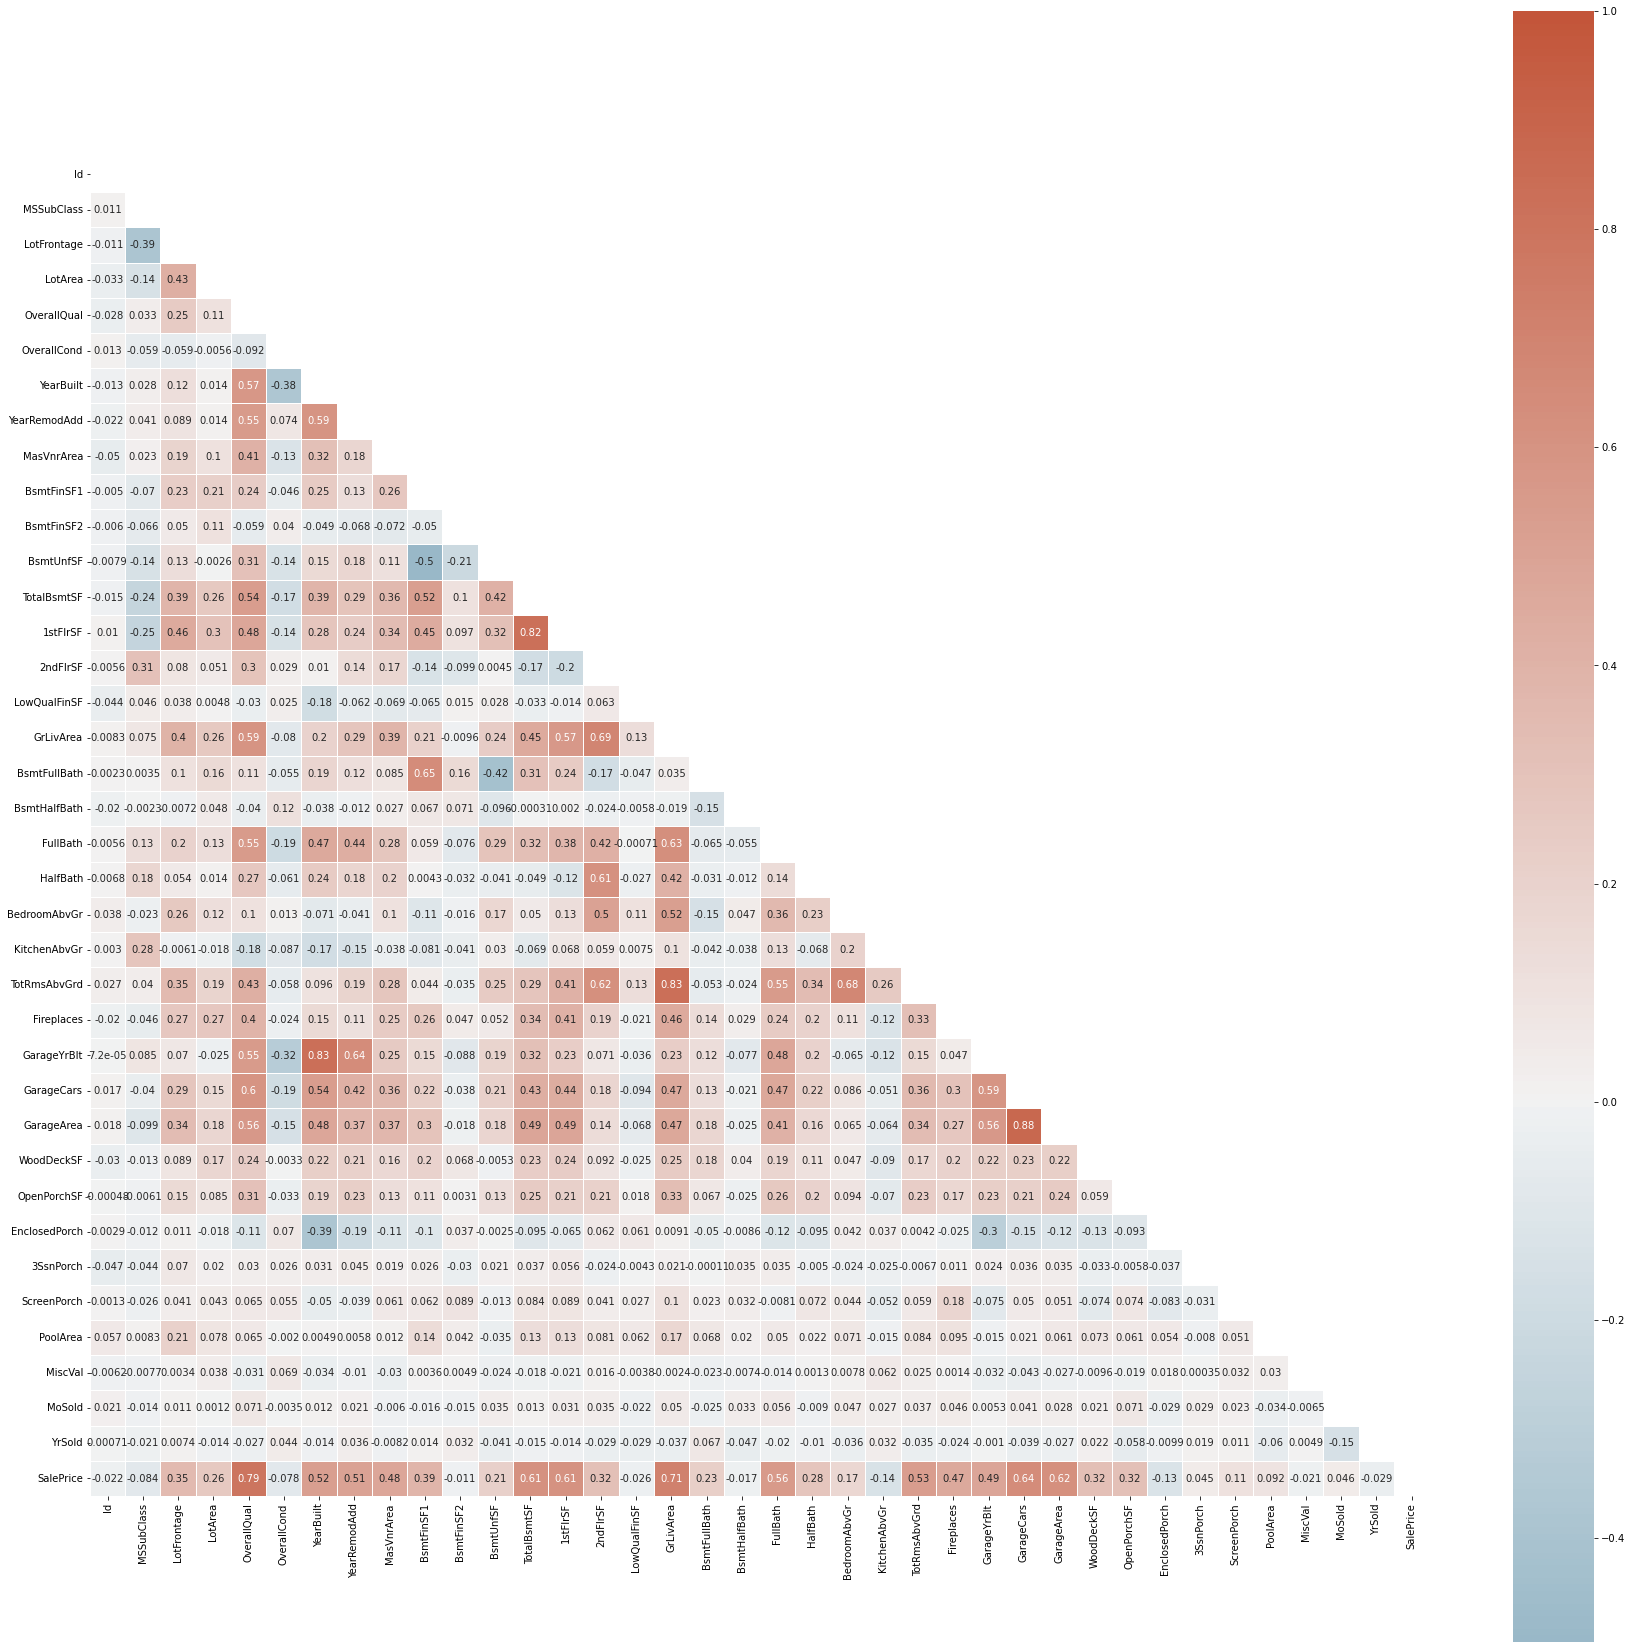

In [5]:
#Create a correlation matrix to see the correlation between independent variables and SalePrice
plt.figure(figsize = (30,30))
corr_matrix = hp_tr.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix,mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5)

In [6]:
signif_list = corr_matrix[corr_matrix['SalePrice']>0.5].all(axis = 1)
signif_list

OverallQual     True
YearBuilt       True
YearRemodAdd    True
TotalBsmtSF     True
1stFlrSF        True
GrLivArea       True
FullBath        True
TotRmsAbvGrd    True
GarageCars      True
GarageArea      True
SalePrice       True
dtype: bool

#### Since we have the list of variables that are highly correlated (>0.5) to the SalePrice target variable, we now explore more on their relation to the SalePrice

In [ ]:
#OverallQuality vs SalePrice
#Since the variable tells the range from which the SalePrice varies on the basis of the Quality of the house
plt.figure(figsize = (25,15))
sns.boxplot(data = hp_tr, x="OverallQual", y = "SalePrice")
plt.title("Overall Quality vs SalePrice")
plt.show()

In [ ]:
hp_tr.YearBuilt.describe()

In [ ]:
#Year Built and Year Re Modified have similar kind of a correlation hence would add a hue for YearRemodAdd
plt.figure(figsize = (14,8))
sns.scatterplot(x="YearBuilt", y="SalePrice",hue = "YearRemodAdd", data=hp_tr)
plt.title("Year Built vs SalePrice vs YearRemodAdd")
plt.show

In [ ]:
#Total Basement Square Feet vs SalePrice
plt.figure(figsize = (14,8))
sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=hp_tr)
plt.title("Total Basement Square Feet vs SalePrice")
plt.show

> Looking at the above scatter plot, we can see that there are some data discrepancies like an outlier somewhere around 6300 SQ Ft mark

In [ ]:
#TotRmsAbvGrd vs SalePrice
#Validating the relation between SalePrice and Number of Rooms above grade

#hp_tr.TotRmsAbvGrd.describe()
plt.figure(figsize = (25,15))
sns.boxplot(data = hp_tr, x="TotRmsAbvGrd", y = "SalePrice")
plt.title(" Number of Rooms above grade vs SalePrice")
plt.show()

In [ ]:
hp_tr.loc[hp_tr['TotRmsAbvGrd'].isin([2,14])]

> Here, we can see that the houses with about 10 rooms have the highest range of selling price as compared to any other count, however we can still see that the mean for the houses with 11 rooms is more than 10.

> Also, we observe that there is a discrepancy in houses with 14 or 2 rooms, we need to rectify that in the data wrangling process

In [ ]:
#GrLivArea vs SalePrice
plt.figure(figsize = (14,8))
sns.scatterplot(x="GrLivArea", y="SalePrice", data=hp_tr)
plt.title("Total Basement Square Feet vs SalePrice")
plt.show

### Data Wrangling Process
#### We would now work on processing the missing data and cleaning the data

> Here, we would join the test data with the train data, clean and wrangle it and then separate it out

In [7]:
dependent = hp_tr['SalePrice']
test_id = hp_te['Id']
hp_te = hp_te.drop(['Id'], axis = 1)
hp_tr_cl = hp_tr.drop(['Id', 'SalePrice'], axis=1)

In [8]:
#We concatenate the test and the train data after backing up SalePrice column from train as it is not present in the test data
hp_tr_te = pd.concat([hp_tr_cl, hp_te], axis = 0, sort = False)

In [ ]:
hp_tr_te.head()

In [9]:
#Checking NAN/Null values in data and creating a dataframe for future reference
null_v = pd.DataFrame(hp_tr_te.isna().sum(),columns = ['Nan_Sum'])
null_v['Perc%'] = (null_v['Nan_Sum']/len(hp_tr_te))*100
null_v = null_v[null_v['Nan_Sum'] > 0]
null_v = null_v.sort_values(by = ['Nan_Sum'])
null_v['Disc_Keep'] = np.where(null_v['Perc%']>30,'Discard', 'Keep')
null_v['DataType'] = hp_tr_te.dtypes
null_v

,Nan_Sum,Perc%,Disc_Keep,DataType
TotalBsmtSF,1,0.034258,Keep,float64
GarageArea,1,0.034258,Keep,float64
GarageCars,1,0.034258,Keep,float64
KitchenQual,1,0.034258,Keep,object
Electrical,1,0.034258,Keep,object
BsmtUnfSF,1,0.034258,Keep,float64
BsmtFinSF2,1,0.034258,Keep,float64
BsmtFinSF1,1,0.034258,Keep,float64
SaleType,1,0.034258,Keep,object
Exterior1st,1,0.034258,Keep,object


In [ ]:
null_v[null_v['DataType'] == object]

> We now fill the missing values of all the text variables with their modes or the average values

> We are not using any imputations here as we would be doing them for the numeric/floating point variables

In [10]:
#As an assumption, we fill the NA values for the qualitative variables to the Mode(value that occurs the most)
hp_tr_te['KitchenQual']  = hp_tr_te['KitchenQual'].fillna('TA')
hp_tr_te['Electrical'] = hp_tr_te['Electrical'].fillna(hp_tr_te['Electrical'].mode()[0])
hp_tr_te['SaleType'] = hp_tr_te['SaleType'].fillna(hp_tr_te['SaleType'].mode()[0])
hp_tr_te['Exterior1st'] = hp_tr_te['Exterior1st'].fillna(hp_tr_te['Exterior1st'].mode()[0])
hp_tr_te['Exterior2nd'] = hp_tr_te['Exterior2nd'].fillna(hp_tr_te['Exterior2nd'].mode()[0])
hp_tr_te['Functional'] = hp_tr_te['Functional'].fillna(hp_tr_te['Functional'].mode()[0])
hp_tr_te['Utilities'] = hp_tr_te['Utilities'].fillna(hp_tr_te['Utilities'].mode()[0])
hp_tr_te['MSZoning'] = hp_tr_te['MSZoning'].fillna(hp_tr_te['MSZoning'].mode()[0])

#For the variables that have significantly high missing values, on the basis of the data description file, we can say that these houses won't have such features and hence have NA as the value. We would replace them with None
for col in ['MasVnrType','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','FireplaceQu','Fence','Alley','MiscFeature','PoolQC','BsmtQual','BsmtExposure','BsmtCond','BsmtFinType1','BsmtFinType2']:
    hp_tr_te[col] = hp_tr_te[col].fillna('None')
    

In [11]:
null_v_ = pd.DataFrame(hp_tr_te.isna().sum(),columns = ['Nan_Sum'])
null_v_['Perc%'] = (null_v_['Nan_Sum']/len(hp_tr_te))*100
null_v_ = null_v[null_v['Nan_Sum'] > 0]
null_v_ = null_v_.sort_values(by = ['Nan_Sum'])
null_v_['Disc_Keep'] = np.where(null_v_['Perc%']>30,'Discard', 'Keep')
null_v_['DataType'] = hp_tr_te.dtypes

null_v_[null_v_['DataType'] == object]

,Nan_Sum,Perc%,Disc_Keep,DataType
KitchenQual,1,0.034258,Keep,object
Electrical,1,0.034258,Keep,object
SaleType,1,0.034258,Keep,object
Exterior1st,1,0.034258,Keep,object
Exterior2nd,1,0.034258,Keep,object
Functional,2,0.068517,Keep,object
Utilities,2,0.068517,Keep,object
MSZoning,4,0.137033,Keep,object
MasVnrType,24,0.822199,Keep,object
BsmtFinType1,79,2.706406,Keep,object


In [12]:
null_v_[null_v_['DataType'] != object]

,Nan_Sum,Perc%,Disc_Keep,DataType
TotalBsmtSF,1,0.034258,Keep,float64
GarageArea,1,0.034258,Keep,float64
GarageCars,1,0.034258,Keep,float64
BsmtUnfSF,1,0.034258,Keep,float64
BsmtFinSF2,1,0.034258,Keep,float64
BsmtFinSF1,1,0.034258,Keep,float64
BsmtHalfBath,2,0.068517,Keep,float64
BsmtFullBath,2,0.068517,Keep,float64
MasVnrArea,23,0.787941,Keep,float64
GarageYrBlt,159,5.447071,Keep,float64


In [ ]:
#To Handle missing values in the numeric variables, we would use multiple imputations. H
# def impute_knn(df):
#     ttn = hp_tr_te.select_dtypes(include=[np.number])
#     ttc = hp_tr_te.select_dtypes(exclude=[np.number])

#     cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
#     cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan

#     for col in cols_nan:
#         imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
#         imp_train = ttn.dropna()          # all indicies which which have no missing data 
#         model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
#         knr = model.fit(imp_train[cols_no_nan], imp_train[col])
#         ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
#     return pd.concat([ttn,ttc],axis=1)

# hp_tr_te = impute_knn(hp_tr_te)

In [30]:
#To Handle missing values in the numeric variables, we would use multiple imputations
from sklearn.impute import KNNImputer
ttn = hp_tr_te.select_dtypes(include=[np.number])
ttc = hp_tr_te.select_dtypes(exclude=[np.number])
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
ttn = pd.DataFrame(imputer.fit_transform(ttn),columns = ttn.columns)

#Reset ttc index
ttc = ttc.reset_index(drop=True)

#Concatenate TTN & TTC
hp_tr_te = pd.concat([ttn,ttc],axis=1)

In [34]:
hp_tr_te.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [37]:
hp_tr_te.isna().sum()[1].sum()

0

> Data is now clean and has all the missing values imputed with estimated data using KNN Imputations